In [26]:
# imports

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [27]:
# a function for pre-processing of dfs:

def pre_process_df(file_path,drop_col1=None,drop_col2=None):
    df = pd.read_csv(file_path)
    if drop_col1 and drop_col2:
      df.drop(columns=[drop_col1, drop_col2], inplace=True) 
    elif drop_col1:
     df.drop(columns=[drop_col1], inplace=True)
    return df    

In [28]:
# We are planning to use enron_spam_subset for our models

In [29]:
enron_spam_subset = pre_process_df(r'/kaggle/input/email-spam-dataset/enronSpamSubset.csv','Unnamed: 0.1','Unnamed: 0')

In [30]:
enron_spam_subset

,Body,Label
0,Subject: stock promo mover : cwtd\n * * * urge...,1
1,Subject: are you listed in major search engine...,1
2,"Subject: important information thu , 30 jun 20...",1
3,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,"Subject: "" bidstogo "" is places to go , things...",1
...,...,...
9995,"Subject: monday 22 nd oct\n louise ,\n do you ...",0
9996,Subject: missing bloomberg deals\n stephanie -...,0
9997,Subject: eops salary survey questionnaire\n we...,0
9998,"Subject: q 3 comparison\n hi louise ,\n i have...",0


# Exploratory data analysis

<Axes: xlabel='Label', ylabel='count'>

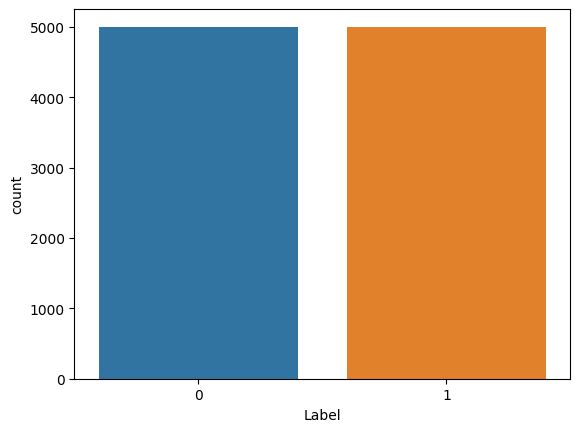

In [31]:
# we are going to work with enron_spam_subset

warnings.simplefilter(action='ignore',category=FutureWarning)
sns.countplot(x = enron_spam_subset['Label'])



In [32]:
# We can see that our data enron_spam_subset which we are planning to use for training are balanced
#in terms of class labels

In [33]:
# checking for NaN values

print(enron_spam_subset.isnull().values.any())

False


In [34]:
# Pre-processing steps:

def pre_process_text(df,col_name, batch_size_pipe=100):
    
    # creating a new df:
    df_processed = df.copy()
    
    # Removing underscores:
    df_processed['Pre-processed'] = df_processed[col_name].apply(lambda text: re.sub(r'_','', text))

    # Converting everything to lower case:
    df_processed['Pre-processed'] = df_processed['Pre-processed'].str.lower()

    # Removing punctations:
    df_processed['Pre-processed'] =df_processed['Pre-processed'].apply(lambda text: re.sub(r'[^\w\s\n]', '', text))

    # Removing leading and trailing white spaces:
    df_processed['Pre-processed'] = df_processed['Pre-processed'].str.strip()
        
    # Removing stop-words:
    
    nlp = spacy.load('en_core_web_sm')
    
    nlp.max_length = 10986104 

    # Create a set of stopwords for English

    stop_words = nlp.Defaults.stop_words
    
    df_processed['Pre-processed'] = df_processed['Pre-processed'].apply(
        lambda text: ' '.join([word for word in text.split() if word not in stop_words])
    )

    # Lemmatizing the emails:
        
    def lemmatize_batch(texts):
        lemmatized_texts = []
        for doc in nlp.pipe(texts,batch_size = batch_size_pipe):
            lemmatized_text = " ".join([token.lemma_ for token in doc])
            lemmatized_texts.append(lemmatized_text)
        return lemmatized_texts
    
    batch_size = 1000
    for i in range(0, len(df_processed),batch_size):
        batch = df_processed.iloc[i:i+batch_size,2].to_list()
        lemmatized_batch = lemmatize_batch(batch)
        df_processed.iloc[i:i+batch_size,2] = lemmatized_batch
        
    return df_processed

In [35]:
dat = pre_process_text(enron_spam_subset,'Body')

In [36]:
dat.to_csv('dat.csv')

In [37]:
dat = pd.read_csv('/kaggle/input/datasetcsv/dat.csv')

In [38]:
dat.drop(columns=['Unnamed: 0'],inplace=True)

In [39]:
dat

,Body,Label,Pre-processed
0,Subject: stock promo mover : cwtd\n * * * urge...,1,subject stock promo mover cwtd urgent investor...
1,Subject: are you listed in major search engine...,1,subject list major search engine submit websit...
2,"Subject: important information thu , 30 jun 20...",1,subject important information thu 30 jun 2005 ...
3,Subject: = ? utf - 8 ? q ? bask your life with...,1,subject utf 8 q bask life utf 8 q individual i...
4,"Subject: "" bidstogo "" is places to go , things...",1,subject bidstogo place go thing hello privacy ...
...,...,...,...
9995,"Subject: monday 22 nd oct\n louise ,\n do you ...",0,subject monday 22 nd oct louise half hour free...
9996,Subject: missing bloomberg deals\n stephanie -...,0,subject miss bloomberg deal stephanie believe ...
9997,Subject: eops salary survey questionnaire\n we...,0,subject eop salary survey questionnaire need e...
9998,"Subject: q 3 comparison\n hi louise ,\n i have...",0,subject q 3 comparison hi louise comparison fi...


In [40]:
# applying tf-idf for generating features

emails = dat['Pre-processed']

# Create a TfidfVectorizer instance
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the text dat_copya to generate TF-IDF vectors
tfidf_vectors = tfidf_vectorizer.fit_transform(emails)

# Convert the TF-IDF vectors to an array for better understanding
tfidf_array = tfidf_vectors.toarray()

# Get the feature names (words) in the vocabulary
feature_names = tfidf_vectorizer.get_feature_names_out()

dat_features = pd.DataFrame(tfidf_array,columns=feature_names)
dat = pd.concat([dat,dat_features],axis = 1)

del dat_features, feature_names, tfidf_vectors, tfidf_array

In [41]:
dat.head()

,Body,Label,Pre-processed,00,000,0000,000000,000000000003619,000000000005168,000000000005409,...,þcomo,þcómo,þeyi,þikayetlerinizi,þtý,þá,þãõ,þí,þîñõþàà,þù
0,Subject: stock promo mover : cwtd\n * * * urge...,1,subject stock promo mover cwtd urgent investor...,0.0,0.012705,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Subject: are you listed in major search engine...,1,subject list major search engine submit websit...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Subject: important information thu , 30 jun 20...",1,subject important information thu 30 jun 2005 ...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Subject: = ? utf - 8 ? q ? bask your life with...,1,subject utf 8 q bask life utf 8 q individual i...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Subject: "" bidstogo "" is places to go , things...",1,subject bidstogo place go thing hello privacy ...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
X_train, X_val, y_train, y_val = train_test_split(dat.iloc[:,3:], dat.iloc[:,1], test_size=0.33, random_state=100)

In [43]:
clf = LogisticRegression(random_state = 100)

In [44]:
clf.fit(X_train,y_train)

LogisticRegression(random_state=100)

In [46]:
y_pred = clf.predict(X_val)

# Calculating precision and recall now

In [47]:
print('Precision is ',precision_score(y_val, y_pred))

Precision is  0.9647887323943662


In [48]:
print('Recall is ',recall_score(y_val, y_pred))

Recall is  0.9945553539019963


# Trying Naive Bayes' Bag of words model 

In [52]:
dat = pd.read_csv('/kaggle/input/datasetcsv/dat.csv')

In [53]:
dat.drop(columns=['Unnamed: 0'],inplace=True)
dat

,Body,Label,Pre-processed
0,Subject: stock promo mover : cwtd\n * * * urge...,1,subject stock promo mover cwtd urgent investor...
1,Subject: are you listed in major search engine...,1,subject list major search engine submit websit...
2,"Subject: important information thu , 30 jun 20...",1,subject important information thu 30 jun 2005 ...
3,Subject: = ? utf - 8 ? q ? bask your life with...,1,subject utf 8 q bask life utf 8 q individual i...
4,"Subject: "" bidstogo "" is places to go , things...",1,subject bidstogo place go thing hello privacy ...
...,...,...,...
9995,"Subject: monday 22 nd oct\n louise ,\n do you ...",0,subject monday 22 nd oct louise half hour free...
9996,Subject: missing bloomberg deals\n stephanie -...,0,subject miss bloomberg deal stephanie believe ...
9997,Subject: eops salary survey questionnaire\n we...,0,subject eop salary survey questionnaire need e...
9998,"Subject: q 3 comparison\n hi louise ,\n i have...",0,subject q 3 comparison hi louise comparison fi...


In [56]:
# using Naive Bayes' Bag of words model with the help of count vectorizer

emails = dat['Pre-processed']

count_vectorizer = CountVectorizer()

count_vectors = count_vectorizer.fit_transform(emails)

count_array = count_vectors.toarray()

# Get the feature names (words) in the vocabulary
feature_names = count_vectorizer.get_feature_names_out()

dat_features = pd.DataFrame(count_array,columns=feature_names)
dat = pd.concat([dat,dat_features],axis = 1)


In [57]:
dat.head()

,Body,Label,Pre-processed,00,000,0000,000000,000000000003619,000000000005168,000000000005409,...,þcomo,þcómo,þeyi,þikayetlerinizi,þtý,þá,þãõ,þí,þîñõþàà,þù
0,Subject: stock promo mover : cwtd\n * * * urge...,1,subject stock promo mover cwtd urgent investor...,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Subject: are you listed in major search engine...,1,subject list major search engine submit websit...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Subject: important information thu , 30 jun 20...",1,subject important information thu 30 jun 2005 ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Subject: = ? utf - 8 ? q ? bask your life with...,1,subject utf 8 q bask life utf 8 q individual i...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Subject: "" bidstogo "" is places to go , things...",1,subject bidstogo place go thing hello privacy ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
X_train, X_val, y_train, y_val = train_test_split(dat.iloc[:,3:], dat.iloc[:,1], test_size=0.33, random_state=100)

In [59]:
clf = MultinomialNB()

In [60]:
clf.fit(X_train, y_train)

MultinomialNB()

In [61]:
y_pred = clf.predict(X_val)

# Calculating precision and recall now

In [62]:
print('Precision is ',precision_score(y_val, y_pred))

Precision is  0.9842328684050939


In [64]:
print('Recall is ',recall_score(y_val, y_pred))

Recall is  0.9818511796733213
